# Importação e Definição de métodos

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torchmetrics
from medpy.metric.binary import hd, asd
import time


import ssl
import urllib.request

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [75]:
class DatasetBreastCancer(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size

        # Define transformations for grayscale images and masks
        self.image_transform = transforms.Compose([
            transforms.Resize(self.image_size),      # Resize image to fixed size
            transforms.ToTensor(),                   # Convert image to PyTorch tensor
        ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=Image.NEAREST),  # Resize mask using nearest neighbor
            transforms.ToTensor(),                                          # Convert mask to tensor
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Open image and mask in grayscale
        image = Image.open(self.image_paths[idx]).convert('L')  # 'L' ensures grayscale (single channel)
        mask = Image.open(self.mask_paths[idx]).convert('L')    # Mask is also in grayscale

        # Apply transformations
        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask

In [76]:
import os
from sklearn.model_selection import train_test_split

base_dir = '../DATA/raw'
categories = ['benign', 'malignant']

train_image_paths = []
val_image_paths = []
train_mask_paths = []
val_mask_paths = []

for category in categories:
    category_dir = os.path.join(base_dir, category)
    category_image_paths = []
    category_mask_paths = []
    
    for fname in os.listdir(category_dir):
        if fname.endswith('_mask.png'):
            category_mask_paths.append(os.path.join(category_dir, fname))
        else:
            category_image_paths.append(os.path.join(category_dir, fname))
    
    # Dividir os caminhos em conjuntos de treino e validação para cada categoria
    train_img, val_img, train_mask, val_mask = train_test_split(
        category_image_paths, category_mask_paths, test_size=0.2, random_state=42
    )
    
    train_image_paths.extend(train_img)
    val_image_paths.extend(val_img)
    train_mask_paths.extend(train_mask)
    val_mask_paths.extend(val_mask)

# Criar instâncias dos datasets de treino e validação
train_dataset = DatasetBreastCancer(train_image_paths, train_mask_paths)
val_dataset = DatasetBreastCancer(val_image_paths, val_mask_paths)

In [77]:
ssl._create_default_https_context = ssl._create_unverified_context

# Definindo o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, masks in dataloader:
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}")

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric, MeanIoU, compute_hausdorff_distance, compute_average_surface_distance
import time  # Importar a biblioteca de tempo

def evaluate_model(model, dataloader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    jaccard_metric = MeanIoU(include_background=True, reduction="mean")
    hausdorff_scores = []
    surface_scores = []

    with torch.no_grad():  # Desabilitar cálculos de gradiente
        total_samples = 0
        elapsed_time = 0

        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            total_samples += batch_size

            # Passagem para frente para obter as previsões do modelo
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            elapsed_time += end_time - start_time
            
            # Aplicar sigmoid ou softmax se necessário (para segmentação binária/multi-classe)
            outputs = torch.sigmoid(outputs) if outputs.shape[1] == 1 else torch.softmax(outputs, dim=1)

            outputs = (outputs > 0.5).float()
            
            # Calcular métricas por lote
            dice_metric(y_pred=outputs, y=targets)
            jaccard_metric(y_pred=outputs, y=targets)
            hausdorff_distance = compute_hausdorff_distance(y_pred=outputs, y=targets).cpu().numpy()
            hausdorff_scores.extend(hausdorff_distance[~np.isinf(hausdorff_distance)])
            
            surface_distance = compute_average_surface_distance(y_pred=outputs, y=targets).cpu().numpy()
            surface_scores.extend(surface_distance[~np.isinf(surface_distance)])
            
            # Plotar comparações de saídas do modelo e alvos para os primeiros 4 lotes
            if i < 4:
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(outputs.cpu().numpy()[0, 0], cmap='gray')
                axes[0].set_title('Previsão do Modelo')
                axes[1].imshow(targets.cpu().numpy()[0, 0], cmap='gray')
                axes[1].set_title('Alvo')
                plt.show()
    
    # Calcular as médias das métricas
    mean_dice = dice_metric.aggregate().item()
    mean_jaccard = jaccard_metric.aggregate().item()
    mean_hausdorff = np.mean(hausdorff_scores)
    mean_surface = np.mean(surface_scores)
    avg_time_per_sample = elapsed_time / total_samples

    print(f"Média do Coeficiente Dice: {mean_dice:.4f}")
    print(f"Média do Índice Jaccard: {mean_jaccard:.4f}")
    print(f"Média da Distância Hausdorff Balanceada: {mean_hausdorff:.4f}")
    print(f"Média da Distância Média de Superfície: {mean_surface:.4f}")
    print(f"Tempo médio para classificar cada amostra: {avg_time_per_sample:.4f} segundos")

# Encoder: DenseNet201 - Decoder: UNET

C:\Users\Vitor\AppData\Local\Temp\ipykernel_26396\2686323693.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet201_unet_model.load_state_dict(torch.load(model_pat

Modelo carregado a partir do disco.


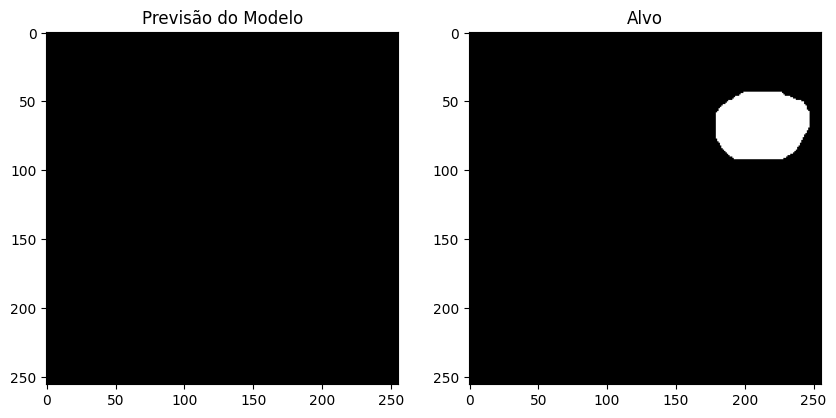

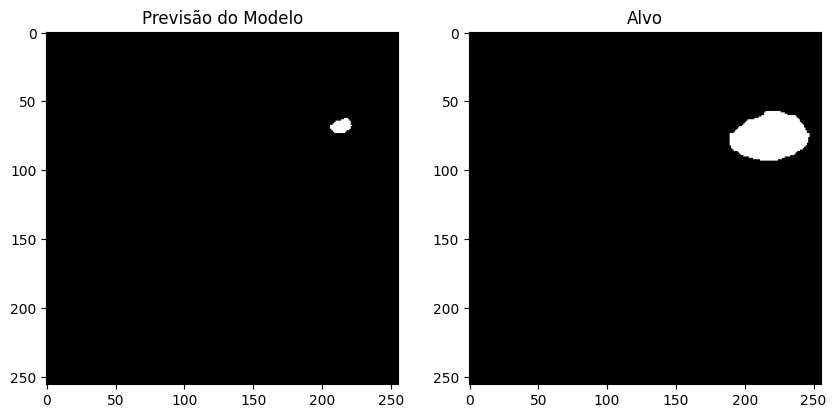

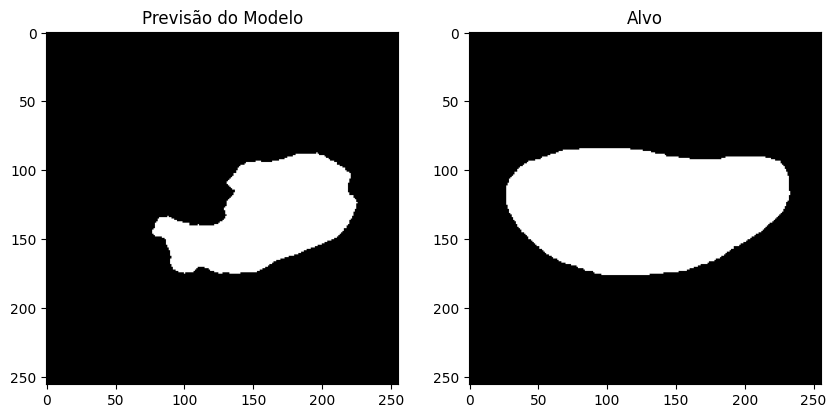

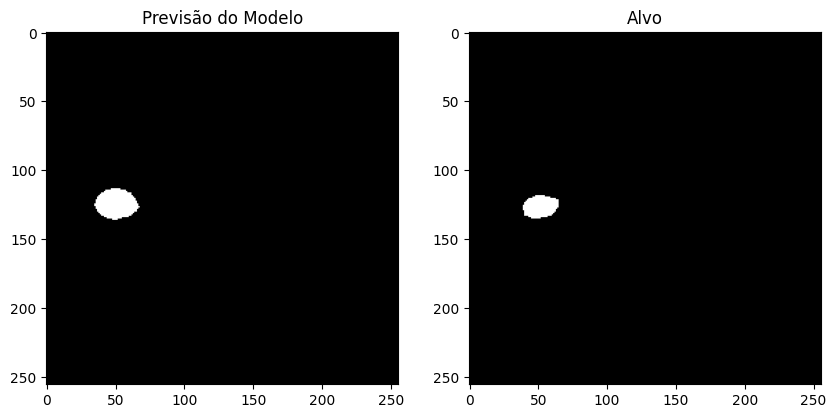

Média do Coeficiente Dice: 0.7591
Média do Índice Jaccard: 0.6743
Média da Distância Hausdorff Balanceada: 32.0675
Média da Distância Média de Superfície: 10.2263
Tempo médio para classificar cada amostra: 0.0153 segundos


In [80]:
import os

# Função de pré-processamento
preprocess_input = get_preprocessing_fn('densenet201', pretrained='imagenet')

# Definindo o modelo
densenet201_unet_model = Unet(encoder_name="densenet201", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(densenet201_unet_model.parameters(), lr=1e-4)

model_path = 'densenet201_unet_model.pth'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

if os.path.exists(model_path):
    densenet201_unet_model.load_state_dict(torch.load(model_path))
    print("Modelo carregado a partir do disco.")
else:
    train_model(densenet201_unet_model, train_dataloader, criterion, optimizer, num_epochs=25)
    # Salvando o modelo
    torch.save(densenet201_unet_model.state_dict(), model_path)
    print("Modelo treinado e salvo no disco.")
    
evaluate_model(densenet201_unet_model, val_dataloader, device)

# Encoder: Resnet152 - Decoder: UNET


C:\Users\Vitor\AppData\Local\Temp\ipykernel_26396\2082846578.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet152_unet_model.load_state_dict(torch.load(model_path)

Modelo carregado a partir do disco.


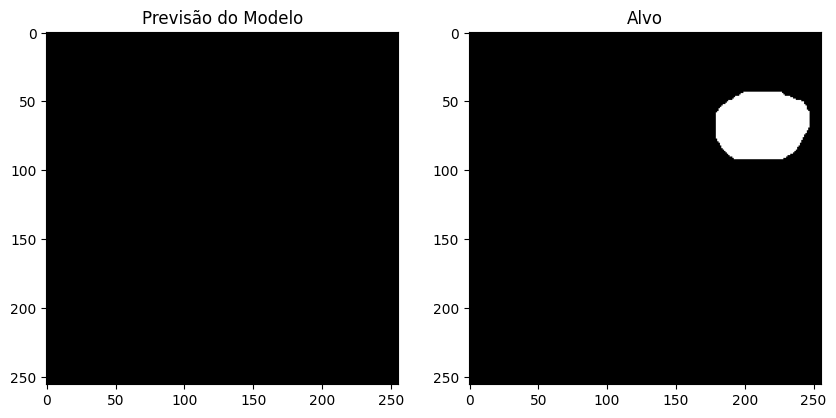

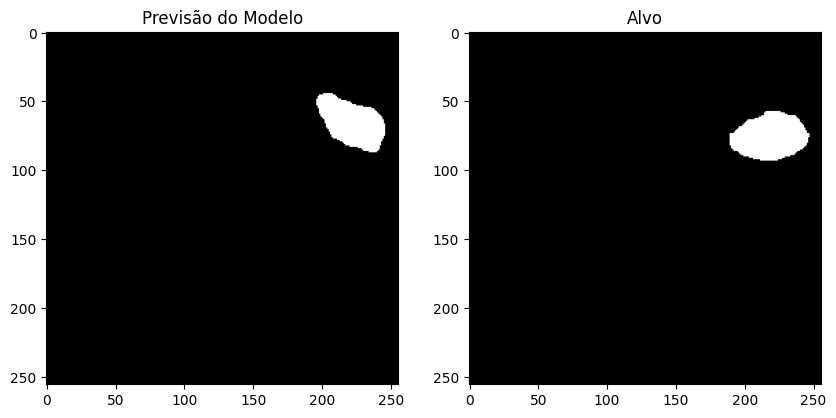

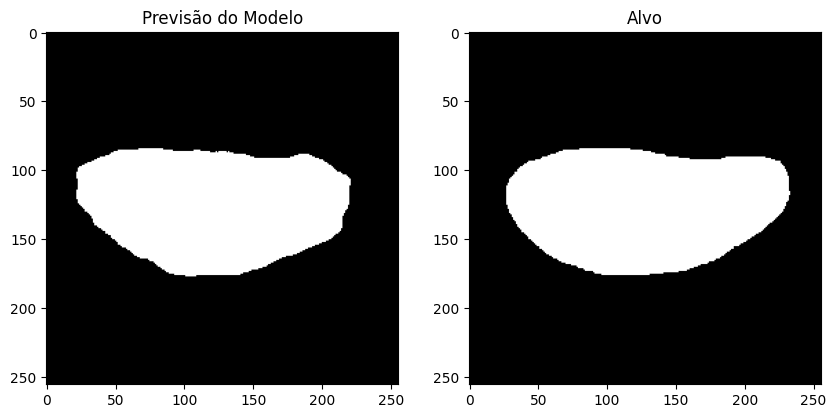

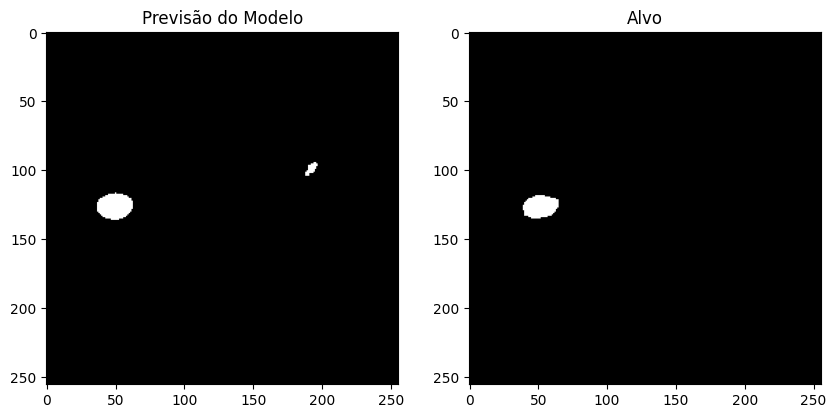

Média do Coeficiente Dice: 0.7463
Média do Índice Jaccard: 0.6598
Média da Distância Hausdorff Balanceada: 31.1743
Média da Distância Média de Superfície: 9.4107
Tempo médio para classificar cada amostra: 0.0109 segundos


In [81]:
# Função de pré-processamento
preprocess_input = get_preprocessing_fn('resnet152', pretrained='imagenet')

# Definindo o modelo
resnet152_unet_model = Unet(encoder_name="resnet152", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet152_unet_model.parameters(), lr=1e-4)

model_path = 'resnet152_unet_model.pth'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

if os.path.exists(model_path):
    resnet152_unet_model.load_state_dict(torch.load(model_path))
    print("Modelo carregado a partir do disco.")
else:
    train_model(resnet152_unet_model, train_dataloader, criterion, optimizer, num_epochs=25)
    
    # Salvando o modelo
    torch.save(resnet152_unet_model.state_dict(), model_path)
    print("Modelo treinado e salvo no disco.")

evaluate_model(resnet152_unet_model, val_dataloader, device)

# Encoder: VGG19 - Decoder: UNET

Epoch 0/24, Loss: 0.5565
Epoch 1/24, Loss: 0.4102
Epoch 2/24, Loss: 0.3448
Epoch 3/24, Loss: 0.2938
Epoch 4/24, Loss: 0.2614
Epoch 5/24, Loss: 0.2325
Epoch 6/24, Loss: 0.2099
Epoch 7/24, Loss: 0.1884
Epoch 8/24, Loss: 0.1756
Epoch 9/24, Loss: 0.1651
Epoch 10/24, Loss: 0.1483
Epoch 11/24, Loss: 0.1383
Epoch 12/24, Loss: 0.1272
Epoch 13/24, Loss: 0.1183
Epoch 14/24, Loss: 0.1099
Epoch 15/24, Loss: 0.1008
Epoch 16/24, Loss: 0.0944
Epoch 17/24, Loss: 0.0863
Epoch 18/24, Loss: 0.0801
Epoch 19/24, Loss: 0.0761
Epoch 20/24, Loss: 0.0694
Epoch 21/24, Loss: 0.0698
Epoch 22/24, Loss: 0.0679
Epoch 23/24, Loss: 0.0745
Epoch 24/24, Loss: 0.0692
Modelo treinado e salvo no disco.


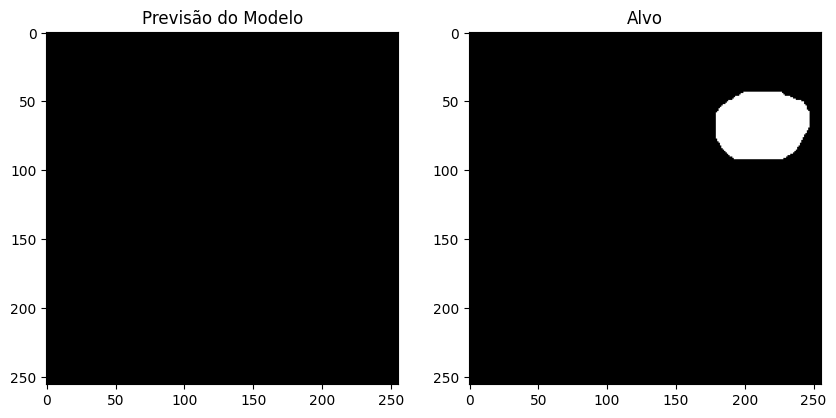

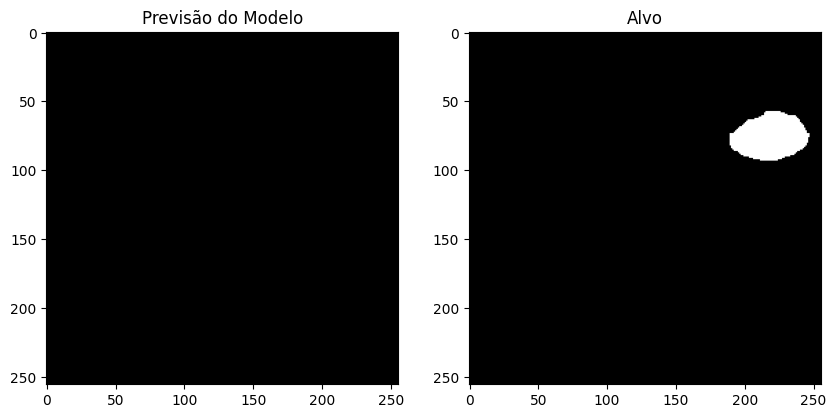

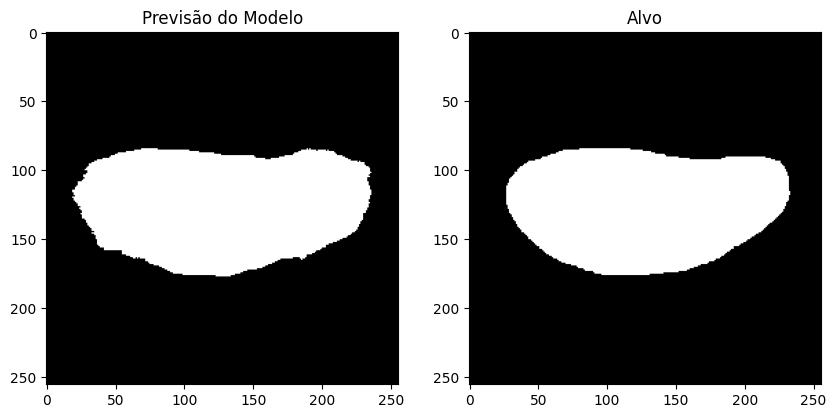

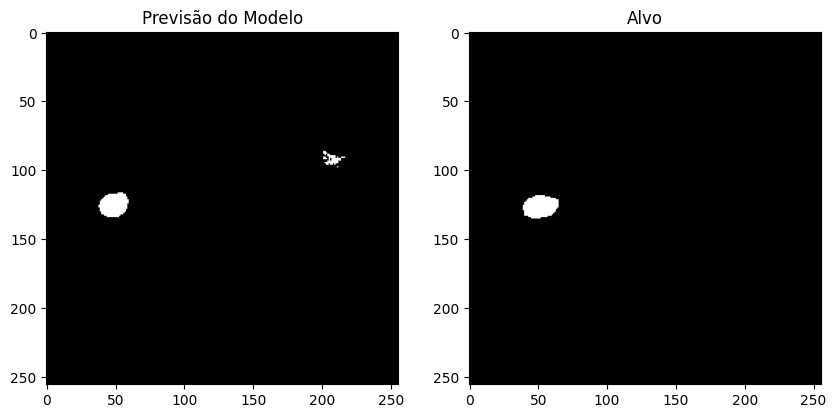

Média do Coeficiente Dice: 0.7414
Média do Índice Jaccard: 0.6607
Média da Distância Hausdorff Balanceada: 39.3181
Média da Distância Média de Superfície: 13.9341
Tempo médio para classificar cada amostra: 0.0122 segundos


In [82]:
# Função de pré-processamento
preprocess_input = get_preprocessing_fn('vgg19', pretrained='imagenet')

# Definindo o modelo
vgg19_unet_model = Unet(encoder_name="vgg19", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg19_unet_model.parameters(), lr=1e-4)

model_path = 'vgg19_unet_model.pth'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

if os.path.exists(model_path):
    vgg19_unet_model.load_state_dict(torch.load(model_path))
    print("Modelo carregado a partir do disco.")
else:
    train_model(vgg19_unet_model, train_dataloader, criterion, optimizer, num_epochs=25)
    
    # Salvando o modelo
    torch.save(vgg19_unet_model.state_dict(), model_path)
    print("Modelo treinado e salvo no disco.")

evaluate_model(vgg19_unet_model, val_dataloader, device)

# Encoder: Xception - Decoder: UNET

Epoch 0/24, Loss: 0.5263
Epoch 1/24, Loss: 0.3430
Epoch 2/24, Loss: 0.2640
Epoch 3/24, Loss: 0.2179
Epoch 4/24, Loss: 0.1836
Epoch 5/24, Loss: 0.1614
Epoch 6/24, Loss: 0.1429
Epoch 7/24, Loss: 0.1308
Epoch 8/24, Loss: 0.1177
Epoch 9/24, Loss: 0.1047
Epoch 10/24, Loss: 0.0981
Epoch 11/24, Loss: 0.0896
Epoch 12/24, Loss: 0.0803
Epoch 13/24, Loss: 0.0758
Epoch 14/24, Loss: 0.0699
Epoch 15/24, Loss: 0.0648
Epoch 16/24, Loss: 0.0607
Epoch 17/24, Loss: 0.0554
Epoch 18/24, Loss: 0.0529
Epoch 19/24, Loss: 0.0510
Epoch 20/24, Loss: 0.0481
Epoch 21/24, Loss: 0.0461
Epoch 22/24, Loss: 0.0443
Epoch 23/24, Loss: 0.0462
Epoch 24/24, Loss: 0.0409
Modelo treinado e salvo no disco.


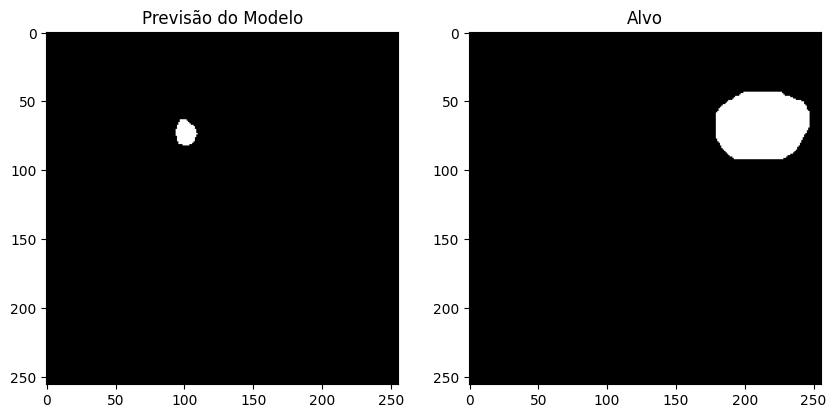

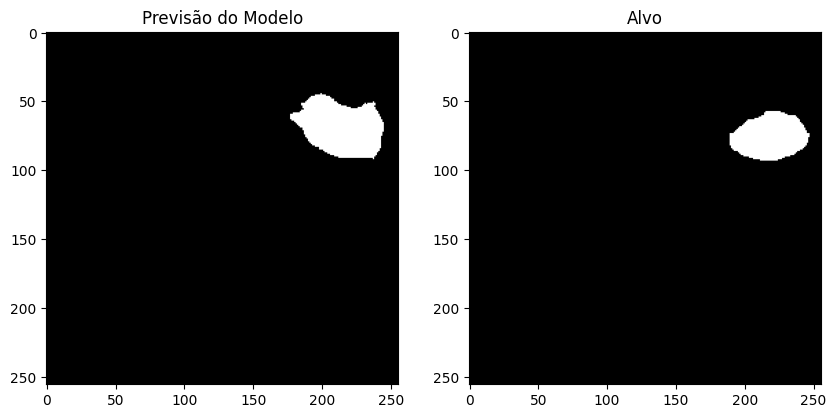

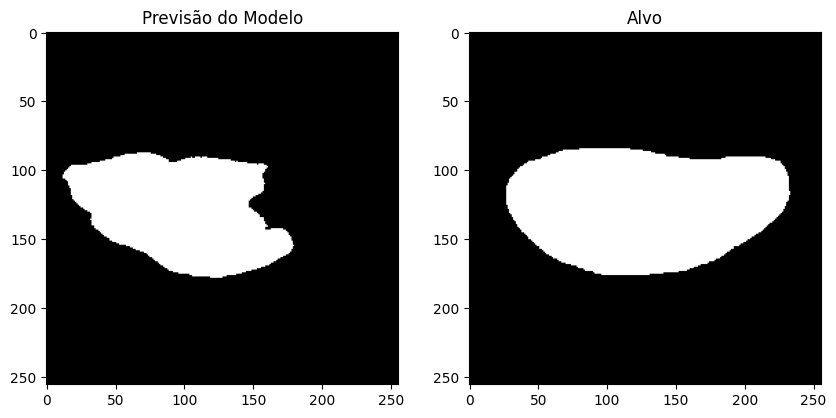

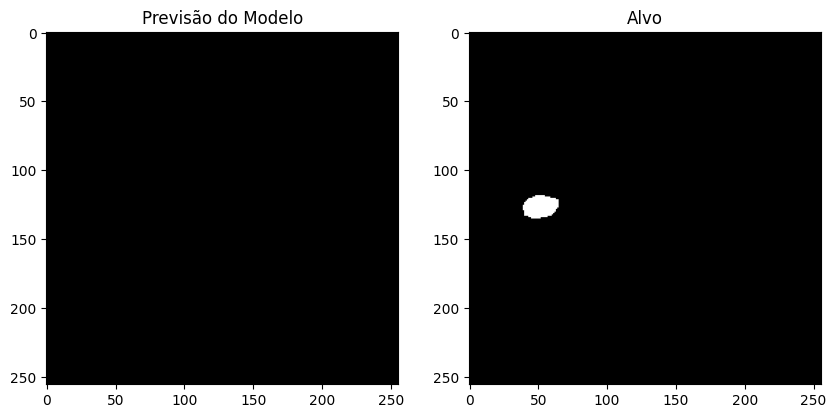

Média do Coeficiente Dice: 0.7323
Média do Índice Jaccard: 0.6375
Média da Distância Hausdorff Balanceada: 46.0802
Média da Distância Média de Superfície: 15.3195
Tempo médio para classificar cada amostra: 0.0032 segundos


In [83]:
# Função de pré-processamento
preprocess_input = get_preprocessing_fn('xception', pretrained='imagenet')

# Definindo o modelo
xception_unet_model = Unet(encoder_name="xception", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(xception_unet_model.parameters(), lr=1e-4)

model_path = 'xception_unet_model.pth'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

if os.path.exists(model_path):
    xception_unet_model.load_state_dict(torch.load(model_path))
    print("Modelo carregado a partir do disco.")
else:
    train_model(xception_unet_model, train_dataloader, criterion, optimizer, num_epochs=25)    
    # Salvando o modelo
    torch.save(xception_unet_model.state_dict(), model_path)
    print("Modelo treinado e salvo no disco.")

evaluate_model(xception_unet_model, val_dataloader, device)

# Encoder: InceptionResNetV2 - Decoder: UNET

Epoch 0/24, Loss: 0.8966
Epoch 1/24, Loss: 0.6437
Epoch 2/24, Loss: 0.5391
Epoch 3/24, Loss: 0.4749
Epoch 4/24, Loss: 0.4230
Epoch 5/24, Loss: 0.3847
Epoch 6/24, Loss: 0.3384
Epoch 7/24, Loss: 0.2869
Epoch 8/24, Loss: 0.2500
Epoch 9/24, Loss: 0.2216
Epoch 10/24, Loss: 0.2002
Epoch 11/24, Loss: 0.1807
Epoch 12/24, Loss: 0.1617
Epoch 13/24, Loss: 0.1491
Epoch 14/24, Loss: 0.1358
Epoch 15/24, Loss: 0.1237
Epoch 16/24, Loss: 0.1160
Epoch 17/24, Loss: 0.1078
Epoch 18/24, Loss: 0.0998
Epoch 19/24, Loss: 0.0928
Epoch 20/24, Loss: 0.0869
Epoch 21/24, Loss: 0.0813
Epoch 22/24, Loss: 0.0754
Epoch 23/24, Loss: 0.0703
Epoch 24/24, Loss: 0.0676
Modelo treinado e salvo no disco.


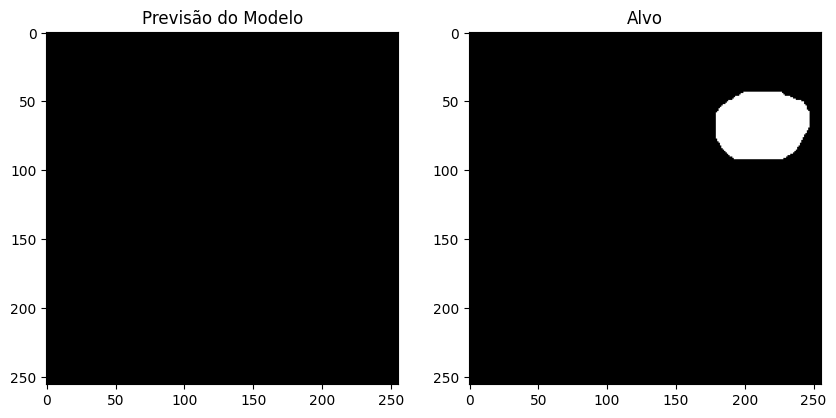

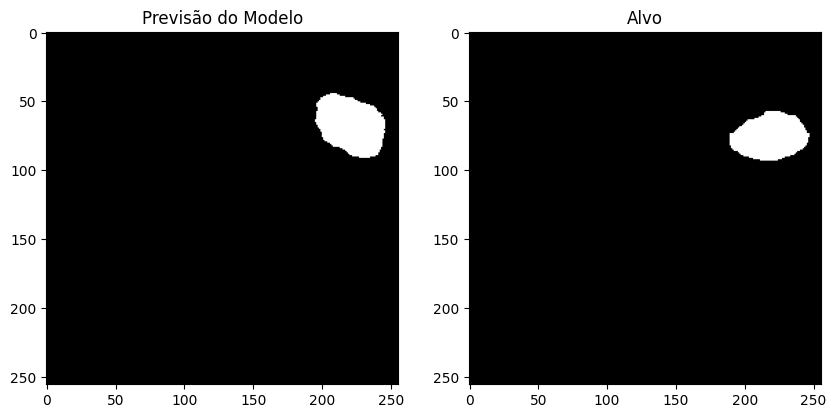

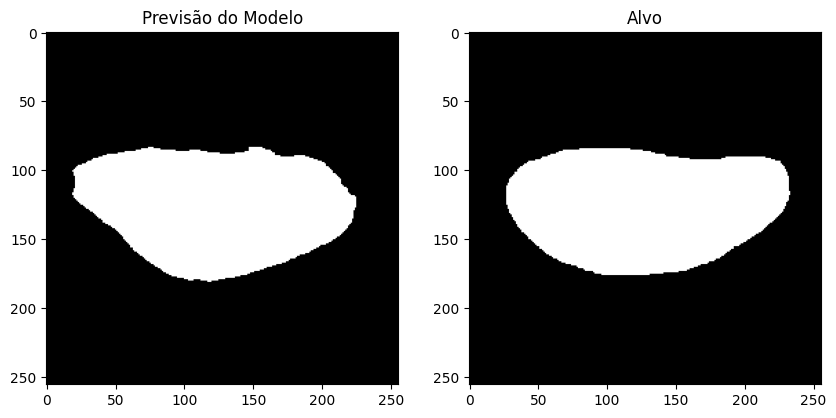

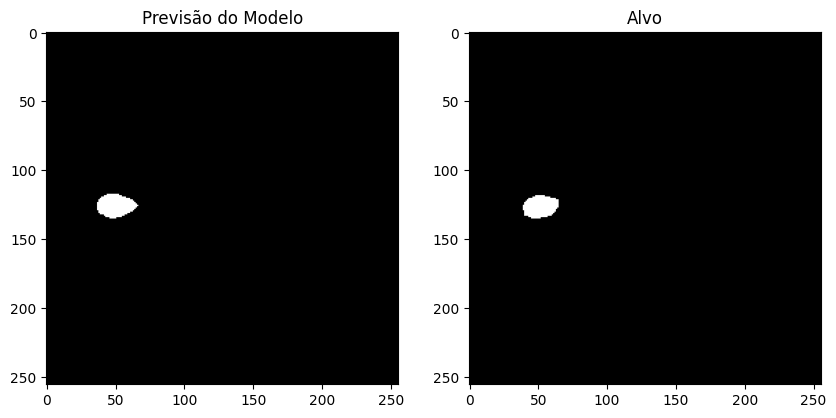

Média do Coeficiente Dice: 0.7518
Média do Índice Jaccard: 0.6652
Média da Distância Hausdorff Balanceada: 33.0805
Média da Distância Média de Superfície: 10.4591
Tempo médio para classificar cada amostra: 0.0205 segundos


In [84]:
# Função de pré-processamento
preprocess_input = get_preprocessing_fn('inceptionresnetv2', pretrained='imagenet')

# Definindo o modelo
inceptionresnetv2_unet_model = Unet(encoder_name="inceptionresnetv2", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(inceptionresnetv2_unet_model.parameters(), lr=1e-4)

model_path = 'inceptionresnetv2_unet_model.pth'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

if os.path.exists(model_path):
    inceptionresnetv2_unet_model.load_state_dict(torch.load(model_path))
    print("Modelo carregado a partir do disco.")
else:
    train_model(inceptionresnetv2_unet_model, train_dataloader, criterion, optimizer, num_epochs=25)
    # Salvando o modelo
    torch.save(inceptionresnetv2_unet_model.state_dict(), model_path)
    print("Modelo treinado e salvo no disco.")

evaluate_model(inceptionresnetv2_unet_model, val_dataloader, device)

# Encoder: MobileNetV2 - Decoder: UNET

Epoch 0/24, Loss: 0.5034
Epoch 1/24, Loss: 0.3556
Epoch 2/24, Loss: 0.2777
Epoch 3/24, Loss: 0.2252
Epoch 4/24, Loss: 0.1969
Epoch 5/24, Loss: 0.1718
Epoch 6/24, Loss: 0.1543
Epoch 7/24, Loss: 0.1402
Epoch 8/24, Loss: 0.1277
Epoch 9/24, Loss: 0.1183
Epoch 10/24, Loss: 0.1087
Epoch 11/24, Loss: 0.0968
Epoch 12/24, Loss: 0.0904
Epoch 13/24, Loss: 0.0860
Epoch 14/24, Loss: 0.0799
Epoch 15/24, Loss: 0.0751
Epoch 16/24, Loss: 0.0708
Epoch 17/24, Loss: 0.0631
Epoch 18/24, Loss: 0.0603
Epoch 19/24, Loss: 0.0554
Epoch 20/24, Loss: 0.0522
Epoch 21/24, Loss: 0.0494
Epoch 22/24, Loss: 0.0452
Epoch 23/24, Loss: 0.0445
Epoch 24/24, Loss: 0.0429
Modelo treinado e salvo no disco.


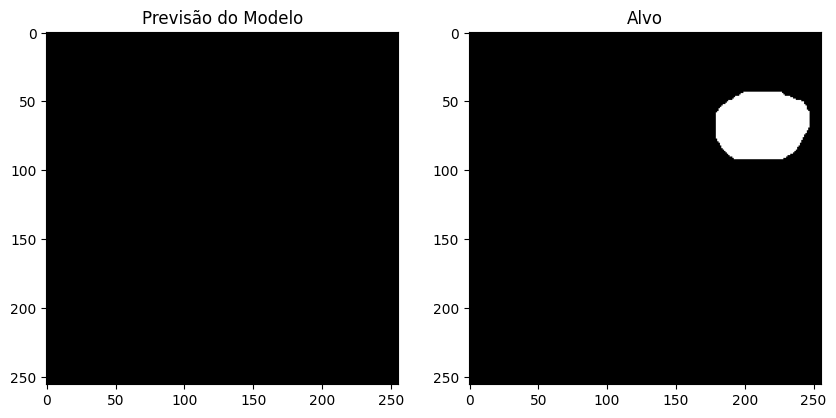

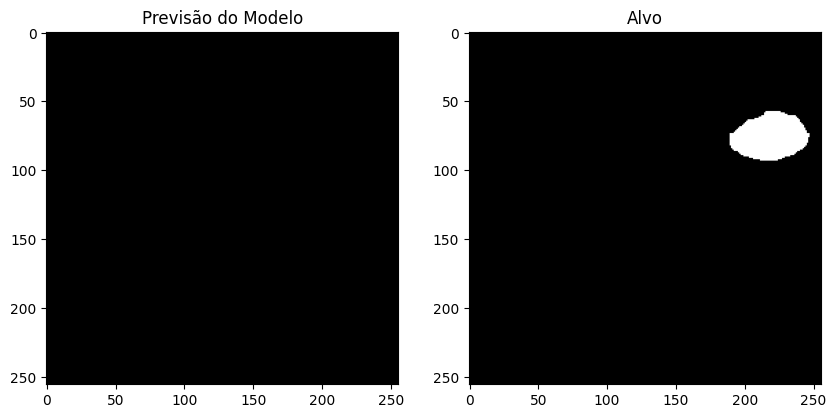

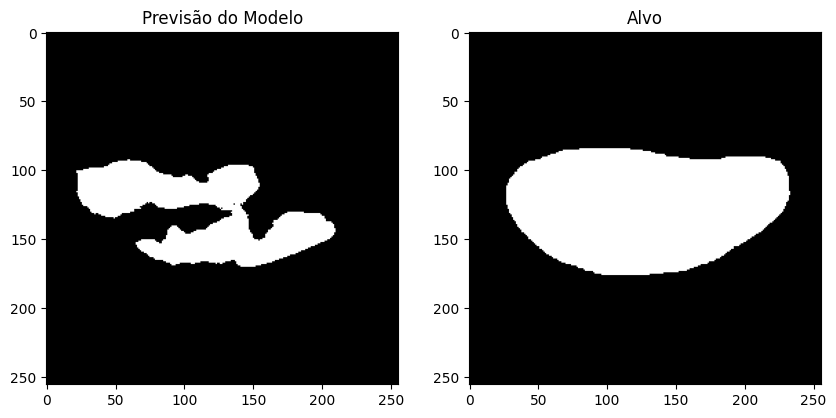

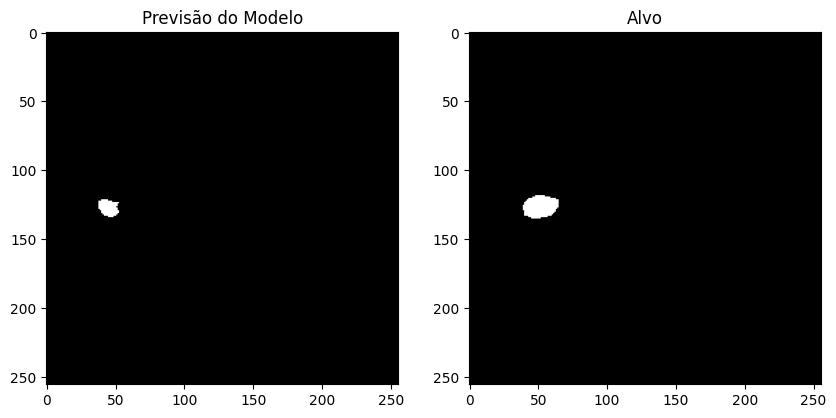

Média do Coeficiente Dice: 0.7288
Média do Índice Jaccard: 0.6326
Média da Distância Hausdorff Balanceada: 39.3705
Média da Distância Média de Superfície: 12.9002
Tempo médio para classificar cada amostra: 0.0022 segundos


In [85]:
# Função de pré-processamento
preprocess_input = get_preprocessing_fn('mobilenet_v2', pretrained='imagenet')

# Definindo o modelo
mobilenetv2_unet_model = Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mobilenetv2_unet_model.parameters(), lr=1e-4)

model_path = 'mobilenetv2_unet_model.pth'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

if os.path.exists(model_path):
    mobilenetv2_unet_model.load_state_dict(torch.load(model_path))
    print("Modelo carregado a partir do disco.")
else:
    train_model(mobilenetv2_unet_model, train_dataloader, criterion, optimizer, num_epochs=25)    
    # Salvando o modelo
    torch.save(mobilenetv2_unet_model.state_dict(), model_path)
    print("Modelo treinado e salvo no disco.")

evaluate_model(mobilenetv2_unet_model, val_dataloader, device)